In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment, SimulatedExperiment

In [3]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="conf"):
    cfg = compose(config_name="config_gaussian")

/tmp/ipykernel_104294/903627929.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="conf"):


In [4]:
model_path = cfg['paths']['model_path']
data = torch.load(cfg['paths']['data_path'])
print(data.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


### setup experiment simulator

In [5]:
from inxss.experiment import Background

In [6]:
background = Background(
    tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), 
    data['grid']['w_grid'], 
    data['background']
)

### Testing integrated steer module

In [7]:
from inxss.steer_neutron import NeutronExperimentSteerer

In [8]:
global_mask = (data['S']>0).bool()

In [9]:
particle_filter_config = {
    "num_particles": 1000,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}

grid_info = {
    'h_grid': [-2.0,  2.0, 121],
    'k_grid': [-2.0,  2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [ 20.0, 200.0, 91]
}

mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": None
}

In [10]:
psi_mask = PsiMask(**mask_config)

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [11]:
from inxss.experiment import SimulatedExperiment
from sklearn.model_selection import train_test_split
idx_plot = 13

spinw_data = torch.load(cfg['paths']['spinw_data_path'])

train_idx, val_test_idx = train_test_split(np.arange(spinw_data['Syy'].shape[0]), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

for ii, i in enumerate(test_idx):
    print(ii, spinw_data['params'][i])
print(spinw_data['params'][test_idx[idx_plot]])


0 tensor([26.4065, -3.4445], dtype=torch.float64)
1 tensor([22.4046,  3.4776], dtype=torch.float64)
2 tensor([20.3975, -1.9879], dtype=torch.float64)
3 tensor([30.6803,  3.0629], dtype=torch.float64)
4 tensor([38.2439,  0.8350], dtype=torch.float64)
5 tensor([20.9757,  1.5469], dtype=torch.float64)
6 tensor([30.9052, -2.5636], dtype=torch.float64)
7 tensor([21.5248, -2.7835], dtype=torch.float64)
8 tensor([31.3150, -0.7569], dtype=torch.float64)
9 tensor([35.3057, -1.8538], dtype=torch.float64)
10 tensor([26.8561, -2.1235], dtype=torch.float64)
11 tensor([22.0734,  0.1368], dtype=torch.float64)
12 tensor([21.0442, -3.3076], dtype=torch.float64)
13 tensor([30.2704, -2.8482], dtype=torch.float64)
14 tensor([35.0231,  0.1786], dtype=torch.float64)
15 tensor([37.1222, -2.8539], dtype=torch.float64)
16 tensor([31.0048, -2.2552], dtype=torch.float64)
17 tensor([24.1704,  3.0938], dtype=torch.float64)
18 tensor([38.9347, -2.0850], dtype=torch.float64)
19 tensor([24.5072,  1.1760], dtype=torch

In [12]:
sim_experiment = SimulatedExperiment(
    spinw_data['q_grid'], spinw_data['w_grid'], 
    spinw_data['Syy'][test_idx[idx_plot]], spinw_data['Szz'][test_idx[idx_plot]],
    neutron_flux=1000
)


In [13]:
sim_experiment.prepare_experiment(psi_mask.hklw_grid)
# sim_experiment.Sqw = sim_experiment.Sqw / sim_experiment.Sqw.sum() * (data['S'] - torch.from_numpy(data['background'])).sum()

In [14]:
experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": torch.from_numpy(data['background']) + \
        .3 * (global_mask * sim_experiment.Sqw),
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background']
}

model = SpecNeuralRepr.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    tqdm_pbar=False, lkhd_dict=cfg['likelihood'], device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


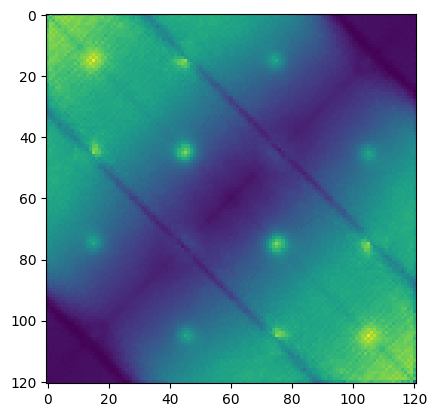

In [15]:
plt.imshow(
    steer.experiment.Sqw.sum(dim=-1).sum(dim=-1).cpu().numpy())

In [32]:

steer.reset()

mean_list = [steer.particle_filter.mean().detach().cpu().clone()]
std_list = [steer.particle_filter.std().detach().cpu().clone()]

posisition_list = [steer.particle_filter.positions.data.T[None].cpu().clone()]
weights_list = [steer.particle_filter.weights.data[None].cpu().clone()]

true_params = spinw_data['params'][test_idx[idx_plot]].numpy()

print('true params: ', true_params)

true params:  [30.27041683 -2.84823474]


In [33]:
with torch.no_grad():
    progress_bar = tqdm(range(10))
    for i in progress_bar:
        steer.step_steer(mode='unique_optimal')
        current_mean = steer.particle_filter.mean().detach().cpu()
        current_std = steer.particle_filter.std().detach().cpu()
        progress_bar.set_description(
            f'means: [{current_mean[0]:.3f}, {current_mean[1]:.3f}] '
            f' stds: [{current_std[0]:.3f}, {current_std[1]:.3f}]'
        )
        mean_list.append(current_mean.clone())
        std_list.append(current_std.clone())
        
        posisition_list.append(steer.particle_filter.positions.data.T[None].cpu().clone())
        weights_list.append(steer.particle_filter.weights.data[None].cpu().clone())
        
        # print('mean: ', current_mean)
        # print('mean v2: ', (steer.particle_filter.positions.data.T * steer.particle_filter.weights.data[:, None]).sum(dim=0))


means: [32.545, -1.242]  stds: [3.321, 2.415]: 100%|██████████| 10/10 [02:18<00:00, 13.84s/it]


In [34]:
sub_result_dict = {
    'means': torch.vstack(mean_list).double(),
    'positions': torch.vstack(posisition_list).double(),
    'weights': torch.vstack(weights_list).double(),
    'measured_angles': torch.from_numpy(np.vstack(steer.measured_angles_history).squeeze()).double(),
    'background_signal_factors': torch.stack(steer.sig_bkg_factors_history).double(),
    'utility': torch.from_numpy(np.vstack(steer.utility_history).squeeze()).double(),
    'likelihood': torch.from_numpy(np.vstack(steer.lkhd_history).squeeze()).double(),
    'true_params': torch.tensor([29.0, 1.68]).double(),
}

In [35]:
_mean_preds = (sub_result_dict['positions'] * sub_result_dict['weights'].unsqueeze(-1)).sum(dim=-2) / sub_result_dict['weights'].sum(dim=-1).unsqueeze(-1)
        

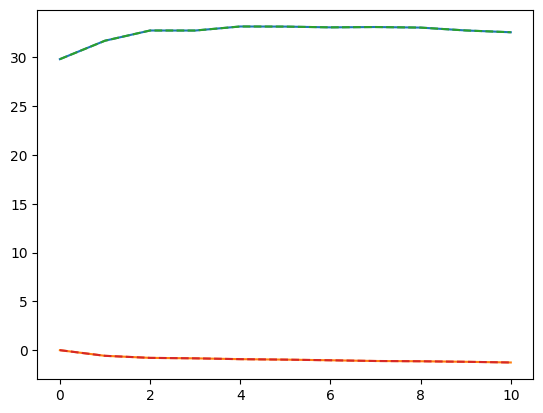

In [36]:
plt.plot(_mean_preds)
plt.plot(sub_result_dict['means'], '--')

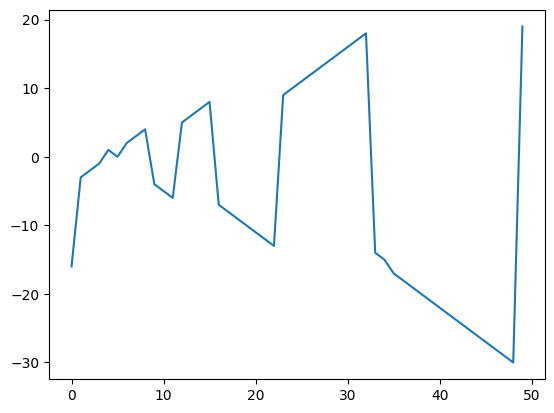

In [18]:
measured_angles = np.vstack(steer.measured_angles_history).squeeze()
measured_angles[measured_angles > 180] -= 360
plt.plot(measured_angles)

In [19]:
from inxss.utils_visualization import visualize_utility

<PolarAxesSubplot:>

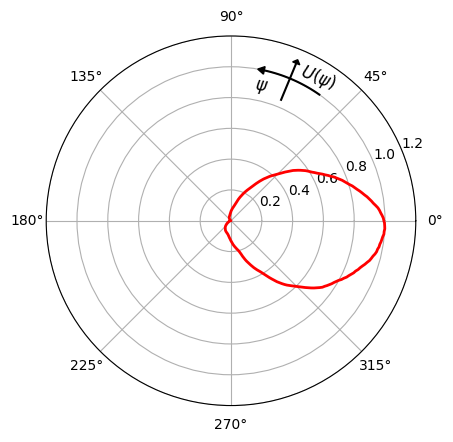

In [20]:
visualize_utility(steer.psi_mask.psi_grid, steer.utility_history[-1])

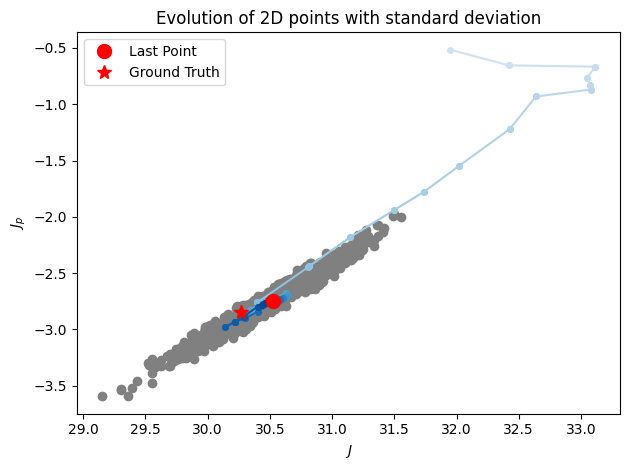

In [21]:
means = torch.vstack(mean_list).detach().numpy()[:]
std_dev = torch.vstack(std_list).detach().numpy()[:]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create some dummy data
scale_factor = 0.25
N = means.shape[0]
# means = np.cumsum(np.random.randn(N, 2), axis=0)
# stds = np.abs(np.random.randn(N, 2))

# Visualization
fig, ax = plt.subplots()

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, N)]

# Plot the evolution of the points with colormap
for i in range(N-1):
    ax.plot(means[i:i+2, 0], means[i:i+2, 1], '-o', color=colors[i], markersize=4)


# # Plot ovals for standard deviation
# for i in range(N):
#     ellipse = patches.Ellipse((means[i, 0], means[i, 1]),
#                               width=std_dev[i, 0]*scale_factor,  
#                               height=std_dev[i, 1]*scale_factor,
#                               edgecolor=None, facecolor=colors[i], alpha=0.2)  
#     ax.add_patch(ellipse)

ax.plot(means[-1,0], means[-1,1], 'o', label='Last Point', markersize=10, color='red')
ax.plot(true_params[0], true_params[1], '*', label='Ground Truth', markersize=10, color='red')

plt.scatter(steer.particle_filter.positions.data[0], steer.particle_filter.positions.data[1], c='gray')

ax.set_title('Evolution of 2D points with standard deviation')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend()

plt.tight_layout()
plt.show()


(-1.0, 51.0)

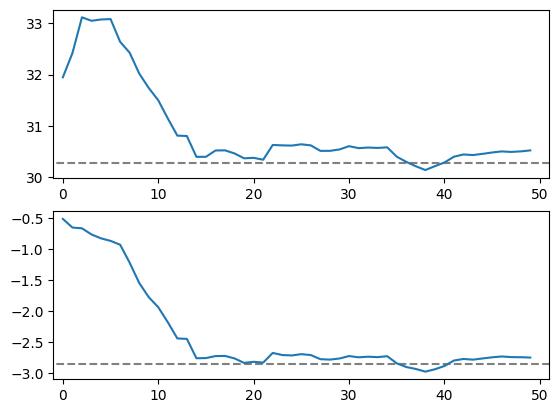

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(means[:,0])
ax[0].hlines([true_params[0],], -10, len(means)+10, color='gray', linestyle='--') 
ax[1].plot(means[:,1])
ax[1].hlines([true_params[1],], -10, len(means)+10, color='gray', linestyle='--')
ax[0].set_xlim([-1, len(means)+1])
ax[1].set_xlim([-1, len(means)+1])

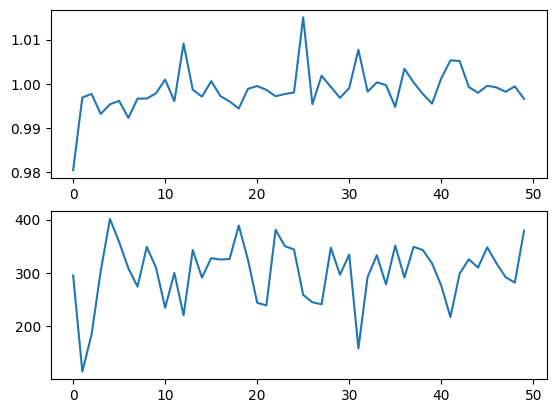

In [23]:
fig, axes = plt.subplots(2,1)
axes[0].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,0])
axes[1].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,1])